In [ ]:
# import libraries
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from scipy.stats import randint
from sklearn.impute import SimpleImputer, KNNImputer
import pandas as pd
import numpy as np

In [1]:
from lussi.stackoverflow import *
from lussi.ziprecruiter import *

"""
Run like this: 
(.venv) hurricane:krijudato afraser$ python ./src/lussi/run.py
"""

# run this to build out your caches.
nogit_data_dir = "622data_nogit"
#build_stack(data_dir=nogit_data_dir)
#build_zip(data_dir=nogit_data_dir)

# this is how you load.
raw_stack  = load_stack(data_dir = nogit_data_dir, stack_type=StackType.RAW)
wide_stack = load_stack(data_dir = nogit_data_dir, stack_type=StackType.WIDE)
ziprecruiter = load_zip(data_dir = nogit_data_dir)

#print(raw_stack.head())
#print(wide_stack.head())
#print(ziprecruiter.head())

In [50]:
# encoding / preprocessing
# filter for US only
us_data = wide_stack[wide_stack['Country'] == 'United States']

# features to keep according to RFE
# 'YearsCodeProAvg', 'OrgSizeAvg', 'AgeAvg', 'EdLevel_Primary',
# 'EdLevel_Something Else', 'python_yes', 'javascript_yes', 'scala_yes',
# 'postgresql_yes', 'ethnicity_grouped_non-minority'

# Function to categorize gender based on the provided rules
def group_gender(gender):
    gender = str(gender).lower()  # Convert to lowercase 
    if 'female' in gender or 'woman' in gender:
        return 'Female'
    elif 'male' in gender or 'man' in gender:
        return 'Male'
    else:
        return 'Other'

# Apply the function to the 'Gender' column to create 'gender_grouped'
us_data.loc[:, 'gender_grouped'] = us_data['Gender'].apply(group_gender)

# removed AgeAvg for test
cols_to_keep = ['AnnualSalary','YearsCodeProAvg', 'OrgSizeAvg', 
                'scala', 'python', 'javascript', 'EdLevel',
                'postgresql', 'ethnicity_grouped', 'AgeAvg', 
               'gender_grouped','aws','mysql','redis','sql',
               'java','ruby','php','c','mongodb',
               'oracle','ibmdb2','sqlite','kubernetes',
               'linux','windows']

# new dataframe with specific columns
df_new = us_data[cols_to_keep].copy()

# Initialize the KNN imputer with the desired number of neighbors (e.g., 5)
knn_imputer = KNNImputer(n_neighbors=5)
# specify numeric columns
numeric_cols = ['YearsCodeProAvg', 'OrgSizeAvg', 'AgeAvg']

# Fit and transform the selected numeric columns in the DataFrame
# Assuming df_new is the DataFrame you want to impute
df_new[numeric_cols] = knn_imputer.fit_transform(df_new[numeric_cols])

/var/folders/vx/nqxyy2hj0lxct6h54j17_5_r0000gn/T/ipykernel_92852/163822571.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_data.loc[:, 'gender_grouped'] = us_data['Gender'].apply(group_gender)


In [51]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df_new['AnnualSalary'].quantile(0.25)
Q3 = df_new['AnnualSalary'].quantile(0.75)

# Calculate the IQR
IQR = Q3 - Q1

# Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers from the dataframe
df_filtered = df_new[(df_new['AnnualSalary'] >= lower_bound) & (df_new['AnnualSalary'] <= upper_bound)]

# Update X and Y with the filtered data
X = df_filtered.drop(columns=['AnnualSalary'])
Y = df_filtered['AnnualSalary']

In [52]:
# One-hot encode categorical variables
X_encoded = pd.get_dummies(X, drop_first=True)

# Identify all boolean columns
bool_cols = X_encoded.select_dtypes(include=['bool']).columns

# Convert boolean columns to integers (True -> 1, False -> 0)
X_encoded[bool_cols] = X_encoded[bool_cols].astype(int)

# Split the dataset into 80% training and 20% testing data
X_train, X_test, Y_train, Y_test = train_test_split(X_encoded, Y, test_size=0.2, random_state=42)

# impute target variable train set
Y_train_imputed = Y_train.copy().values.reshape(-1, 1)  
Y_train_imputed = knn_imputer.fit_transform(Y_train_imputed)

In [36]:
#from sklearn.feature_selection import RFE

#model = xgb.XGBRegressor()
#rfe = RFE(model, n_features_to_select=10)  # Select top 10 features
#fit = rfe.fit(X_train, Y_train_imputed)
#print(fit.support_)  # Boolean mask of selected features

# Get the names of the features
#feature_names = X_train.columns

# Create a DataFrame to show selected features
#selected_features = feature_names[selected_features_mask]
#print(selected_features)

# selects which features to keep in the model

[ True  True  True False False False False False False  True False False
 False False False False  True  True False  True  True  True  True]


NameError: name 'selected_features_mask' is not defined

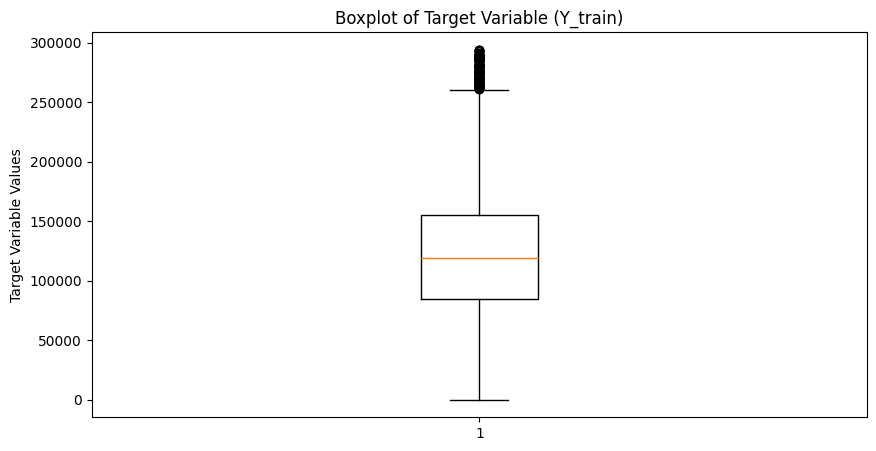

In [53]:
plt.figure(figsize=(10, 5))
plt.boxplot(Y_train_imputed)
plt.title('Boxplot of Target Variable (Y_train)')
plt.ylabel('Target Variable Values')
plt.show()

<Axes: >

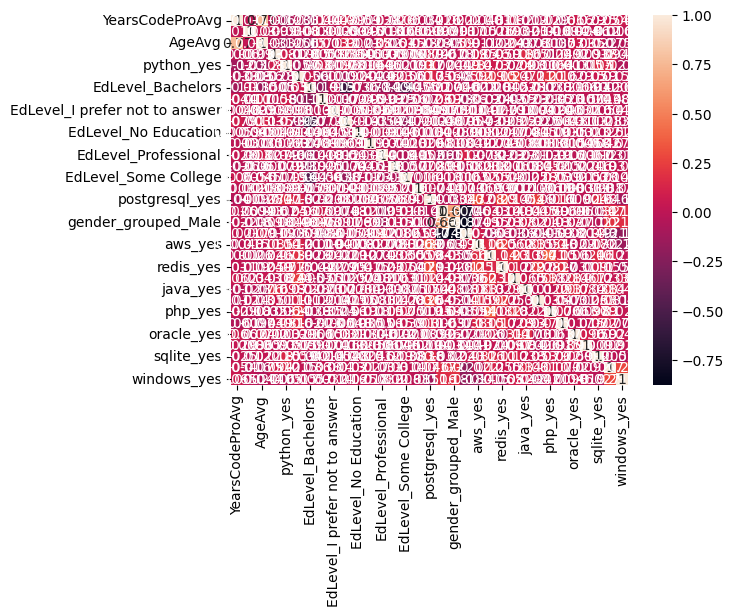

In [54]:
import seaborn as sns
corr_matrix = X_train.corr()
sns.heatmap(corr_matrix, annot=True)

In [55]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': randint(100, 500),
     'max_depth': randint(3, 10),
     'learning_rate': [0.001, 0.01, 0.1, 0.3],
     'subsample': [0.6, 0.8, 1.0],
     'colsample_bytree': [0.6, 0.8, 1.0],
     'gamma': [0, 0.1, 0.3, 0.5],
     'min_child_weight': [1, 5, 10]
}

# Instantiate the model and RandomizedSearchCV
xgb_r = xgb.XGBRegressor(objective='reg:squarederror', seed=123)
random_search = RandomizedSearchCV(estimator=xgb_r, 
                                   param_distributions=param_grid, 
                                   n_iter=50, 
                                   scoring='neg_mean_squared_error', 
                                   cv=5, 
                                   verbose=1, 
                                   random_state=42)

# Fit the random search model
random_search.fit(X_train, Y_train_imputed)
print(f"Best parameters: {random_search.best_params_}")

# Predict using the best model
best_model = random_search.best_estimator_
pred = best_model.predict(X_test)

# Assuming Y_test is a pandas Series - we're only imputing the test to compute RMSE
Y_test_imputed = Y_test.copy()  # Create a copy to avoid modifying the original
Y_test_imputed.fillna(Y_test_imputed.mean(), inplace=True)  # Mean imputation

rmse = np.sqrt(mean_squared_error(Y_test_imputed, pred))
print(f"Optimized RMSE: {rmse}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters: {'colsample_bytree': 1.0, 'gamma': 0.3, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 223, 'subsample': 1.0}
Optimized RMSE: 42604.70118164337


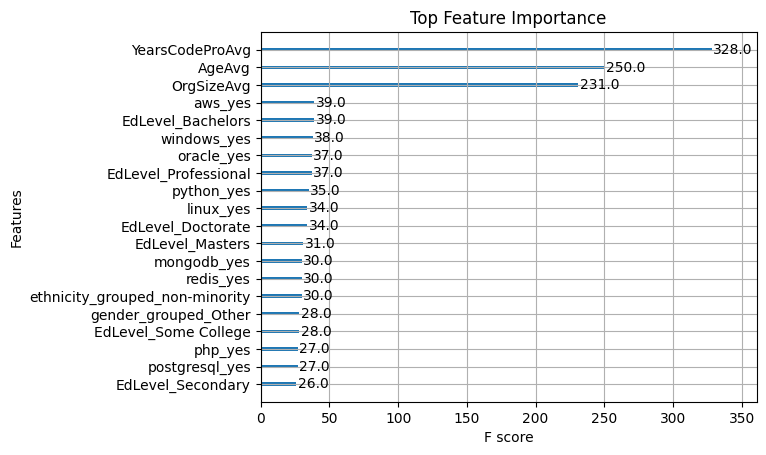

In [56]:
# Plot feature importance
xgb.plot_importance(best_model, importance_type='weight', max_num_features=20)
plt.title('Top Feature Importance')
plt.show()

In [57]:
from sklearn.metrics import r2_score

# Predict the model on the test data
pred = random_search.predict(X_test)

# Compute the R² score
r2 = r2_score(Y_test_imputed, pred)
print("R²: %f" % r2)

R²: 0.378466


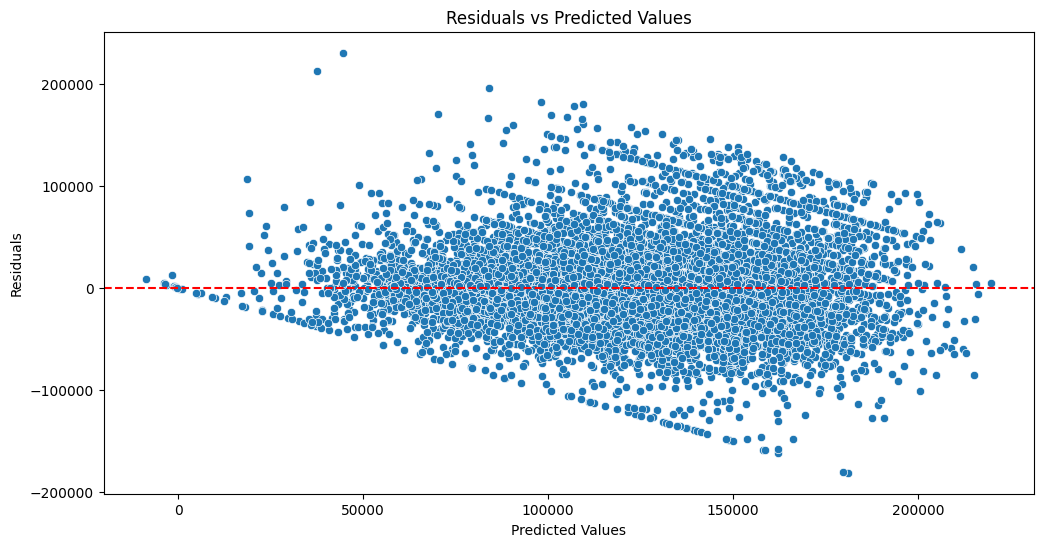

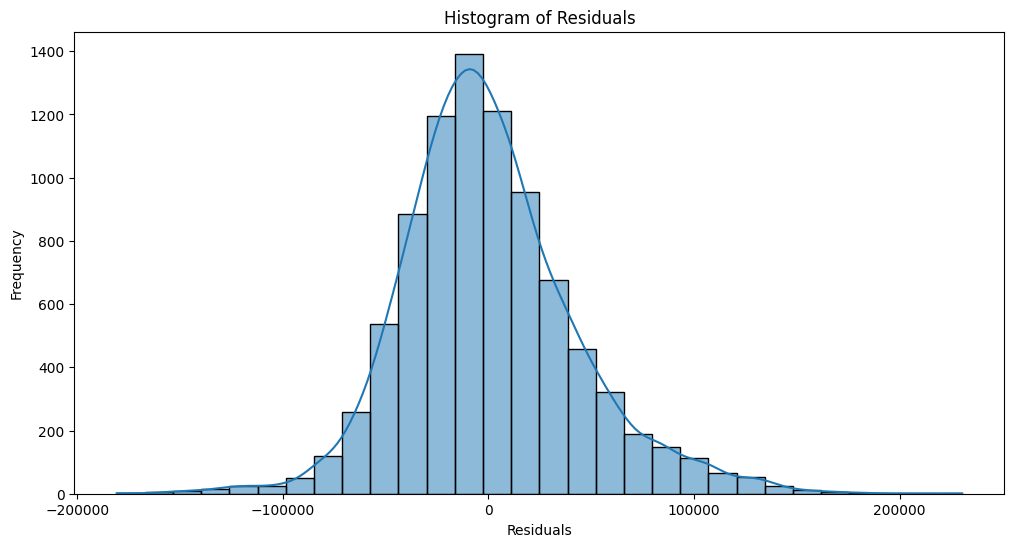

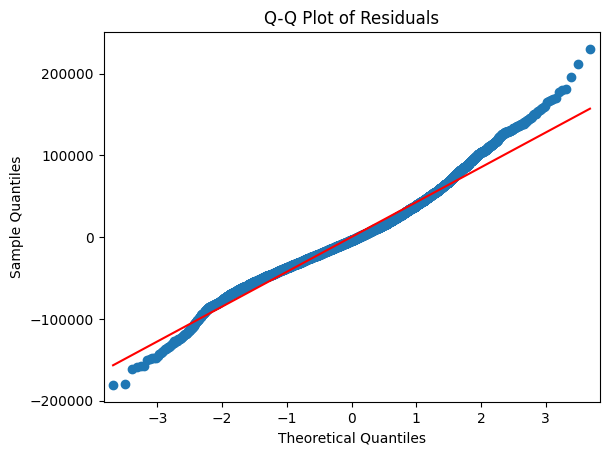

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Assuming you have your predicted and actual values
#pred = best_model.predict(X_test)  # Predictions from the model
residuals = Y_test_imputed - pred  # Calculate residuals

# Create a DataFrame for easier plotting
residuals_df = pd.DataFrame({
    'Actual': Y_test_imputed,
    'Predicted': pred,
    'Residuals': residuals
})

# Plot Residuals vs Predicted Values
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Predicted', y='Residuals', data=residuals_df)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

# Histogram of Residuals
plt.figure(figsize=(12, 6))
sns.histplot(residuals, bins=30, kde=True)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Q-Q Plot
sm.qqplot(residuals, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()
